In [29]:
import sys
sys.path.insert(0,'..')
import tensorflow as tf
from abc import ABC
from abc import abstractmethod
import os
import shutil
import subprocess
import tensorflow as tf
from utils.misc_utils import auto_barrier as auto_barrier_impl
from utils.misc_utils import is_primary_worker as is_primary_worker_impl
from utils.multi_gpu_wrapper import MultiGpuWrapper as mgw
import argparse
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from datasets.abstract_dataset import AbstractDataset
FLAGS = argparse.ArgumentParser()
# FLAGS = parser.parse_args()
FLAGS.enbl_multi_gpu = False
FLAGS.data_disk = 'local'


FLAGS.cycle_length = 4
FLAGS.nb_threads = 1
FLAGS.buffer_size = 1024
FLAGS.prefetch_size = 8


FLAGS.data_dir_local = '../data/cifar-10-batches-bin/'
FLAGS.nb_classes = 10
FLAGS.batch_size = 10000
FLAGS.batch_size_eval = 10000
# FLAGS.data_dir_local = '../data/miml_dataset/bin'
# FLAGS.nb_classes = 5
# FLAGS.batch_size = 32
# FLAGS.batch_size_eval = 32


# FLAGS.
# FLAGS.
# FLAGS.
# FLAGS.
# FLAGS.

In [30]:

class AbstractDataset(ABC):
  '''Abstract class for datasets.'''

  def __init__(self, is_train):
    """Constructor function.

    Args:
    * is_train: whether to construct the training subset
    """

    # following attributes must be initialized by each sub-class
    self.file_pattern = None
    self.dataset_fn = None
    self.parse_fn = None
    self.batch_size = None

    # determine whether data sharding is enabled
    self.is_train = is_train
    self.enbl_shard = (is_train and FLAGS.enbl_multi_gpu)  # shard files for multi-GPU training

  def build(self, enbl_trn_val_split=False):
    '''Build iterator(s) for tf.data.Dataset() object.

    Args:
    * enbl_trn_val_split: whether to split into training & validation subsets

    Returns:
    * iterator_trn: iterator for the training subset
    * iterator_val: iterator for the validation subset
      OR
    * iterator: iterator for the chosen subset (training OR testing)

    Example:
      # build iterator(s)
      dataset = xxxxDataset(is_train=True)  # TF operations are not created
      iterator = dataset.build()            # TF operations are created
          OR
      iterator_trn, iterator_val = dataset.build(enbl_trn_val_split=True)  # for dataset-train only

      # use the iterator to obtain a mini-batch of images & labels
      images, labels = iterator.get_next()
    '''

    # obtain list of data files' names
    filenames = tf.data.Dataset.list_files(self.file_pattern, shuffle=False)
    if self.enbl_shard:
      filenames = filenames.shard(mgw.size(), mgw.rank())

    # create a tf.data.Dataset from list of files
    dataset = filenames.apply(
      tf.contrib.data.parallel_interleave(self.dataset_fn, cycle_length=FLAGS.cycle_length))
    dataset = dataset.map(self.parse_fn, num_parallel_calls=FLAGS.nb_threads)

    # create iterators for training & validation subsets separately
    if self.is_train and enbl_trn_val_split:
      iterator_val = self.__make_iterator(dataset.take(FLAGS.nb_smpls_val))
      iterator_trn = self.__make_iterator(dataset.skip(FLAGS.nb_smpls_val))
      return iterator_trn, iterator_val

    return self.__make_iterator(dataset)

  def __make_iterator(self, dataset):
    """Make an iterator from tf.data.Dataset.

    Args:
    * dataset: tf.data.Dataset object

    Returns:
    * iterator: iterator for the dataset
    """

#     dataset = dataset.apply(tf.contrib.data.shuffle_and_repeat(buffer_size=FLAGS.buffer_size))
    dataset = dataset.batch(self.batch_size)
    dataset = dataset.prefetch(FLAGS.prefetch_size)
    iterator = dataset.make_one_shot_iterator()

    return iterator


In [35]:
# MIML specifications
LABEL_BYTES = 1
IMAGE_HEI = 32
IMAGE_WID = 32
# IMAGE_HEI = 224
# IMAGE_WID = 224
IMAGE_CHN = 3
IMAGE_BYTES = IMAGE_CHN * IMAGE_HEI * IMAGE_WID
RECORD_BYTES = LABEL_BYTES + IMAGE_BYTES
IMAGE_AVE = tf.constant([[[125.3, 123.0, 113.9]]], dtype=tf.float32)
IMAGE_STD = tf.constant([[[63.0, 62.1, 66.7]]], dtype=tf.float32)

def parse_fn(example_serialized, is_train):
  """Parse image & labels from the serialized data.

  Args:
  * example_serialized: serialized example data
  * is_train: whether data augmentation should be applied

  Returns:
  * image: image tensor
  * label: one-hot label tensor
  """

  # data parsing
  record = tf.decode_raw(example_serialized, tf.uint8)
  label = tf.slice(record, [0], [LABEL_BYTES])
  label = tf.one_hot(tf.reshape(label, []), FLAGS.nb_classes)
  image = tf.slice(record, [LABEL_BYTES], [IMAGE_BYTES])
  image = tf.reshape(image, [IMAGE_CHN, IMAGE_HEI, IMAGE_WID])
  image = tf.cast(tf.transpose(image, [1, 2, 0]), tf.float32)
  image = (image - IMAGE_AVE) / IMAGE_STD

  # data augmentation
  if is_train:
    image = tf.image.resize_image_with_crop_or_pad(image, IMAGE_HEI + 8, IMAGE_WID + 8)
    image = tf.random_crop(image, [IMAGE_HEI, IMAGE_WID, IMAGE_CHN])
    image = tf.image.random_flip_left_right(image)

  return image, label

class MIMLDataset(AbstractDataset):
  '''MIML-10 dataset.'''

  def __init__(self, is_train):
    """Constructor function.

    Args:
    * is_train: whether to construct the training subset
    """

    # initialize the base class
    super(MIMLDataset, self).__init__(is_train)

    # choose local files or HDFS files w.r.t. FLAGS.data_disk
    if FLAGS.data_disk == 'local':
      assert FLAGS.data_dir_local is not None, '<FLAGS.data_dir_local> must not be None'
      data_dir = FLAGS.data_dir_local
    elif FLAGS.data_disk == 'hdfs':
      assert FLAGS.data_hdfs_host is not None and FLAGS.data_dir_hdfs is not None, \
        'both <FLAGS.data_hdfs_host> and <FLAGS.data_dir_hdfs> must not be None'
      data_dir = FLAGS.data_hdfs_host + FLAGS.data_dir_hdfs
    else:
      raise ValueError('unrecognized data disk: ' + FLAGS.data_disk)

    # configure file patterns & function handlers
    if is_train:
      self.file_pattern = os.path.join(data_dir, 'data_batch_*.bin')
      self.batch_size = FLAGS.batch_size
    else:
      self.file_pattern = os.path.join(data_dir, 'test_batch_*.bin')
      self.batch_size = FLAGS.batch_size_eval

    self.dataset_fn = lambda x: tf.data.FixedLengthRecordDataset(x, RECORD_BYTES)
    self.parse_fn = lambda x: parse_fn(x, is_train=is_train)



class Cifar10Dataset(AbstractDataset):
  '''CIFAR-10 dataset.'''

  def __init__(self, is_train):
    """Constructor function.

    Args:
    * is_train: whether to construct the training subset
    """

    # initialize the base class
    super(Cifar10Dataset, self).__init__(is_train)

    # choose local files or HDFS files w.r.t. FLAGS.data_disk
    if FLAGS.data_disk == 'local':
      assert FLAGS.data_dir_local is not None, '<FLAGS.data_dir_local> must not be None'
      data_dir = FLAGS.data_dir_local
    elif FLAGS.data_disk == 'hdfs':
      assert FLAGS.data_hdfs_host is not None and FLAGS.data_dir_hdfs is not None, \
        'both <FLAGS.data_hdfs_host> and <FLAGS.data_dir_hdfs> must not be None'
      data_dir = FLAGS.data_hdfs_host + FLAGS.data_dir_hdfs
    else:
      raise ValueError('unrecognized data disk: ' + FLAGS.data_disk)

    # configure file patterns & function handlers
    if is_train:
      self.file_pattern = os.path.join(data_dir, 'data_batch_*.bin')
      self.batch_size = FLAGS.batch_size
    else:
      self.file_pattern = os.path.join(data_dir, 'test_batch.bin')
      self.batch_size = FLAGS.batch_size_eval
    self.dataset_fn = lambda x: tf.data.FixedLengthRecordDataset(x, RECORD_BYTES)
    self.parse_fn = lambda x: parse_fn(x, is_train=is_train)


10000.0 30730000
frog


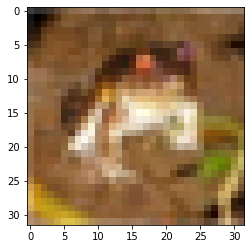

truck


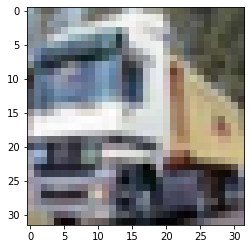

truck


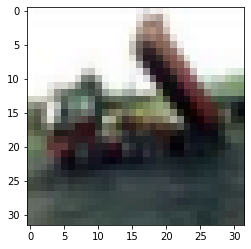

deer


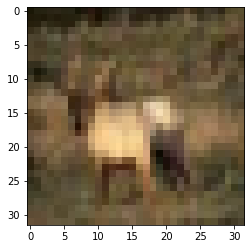

automobile


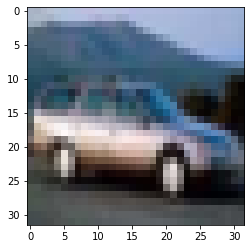

automobile


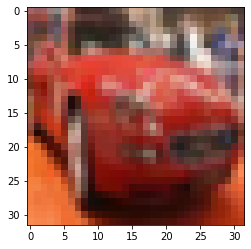

bird


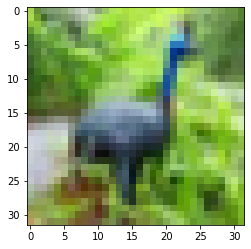

horse


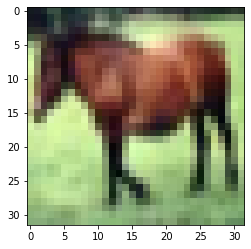

ship


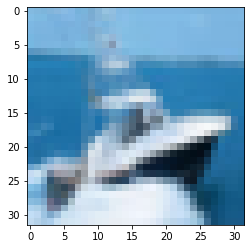

cat


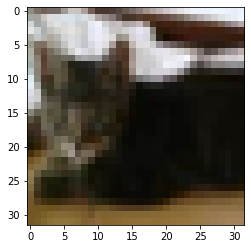

deer


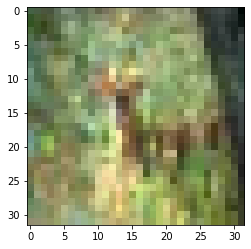

horse


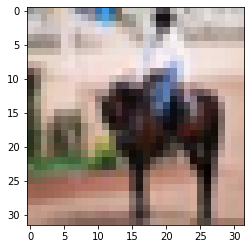

horse


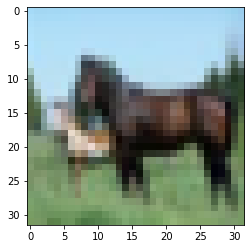

bird


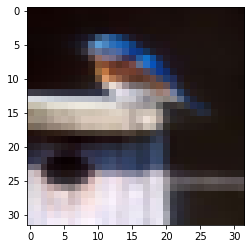

truck


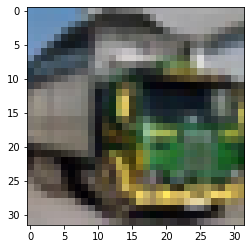

truck


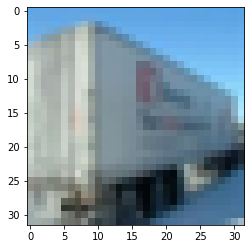

truck


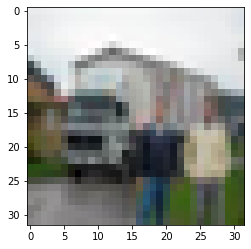

cat


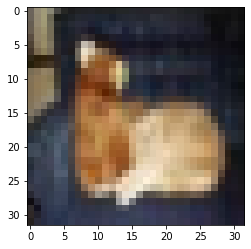

bird


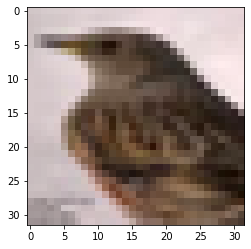

frog


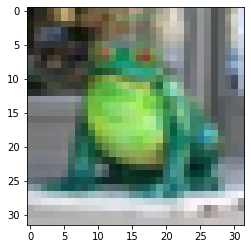

deer


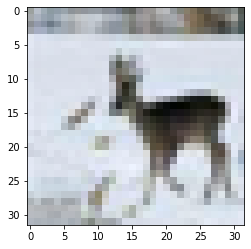

cat


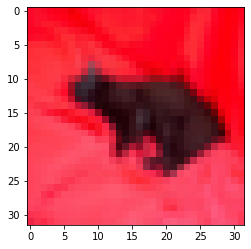

frog


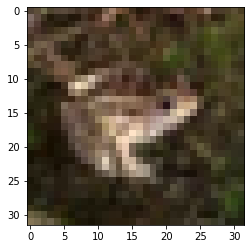

frog


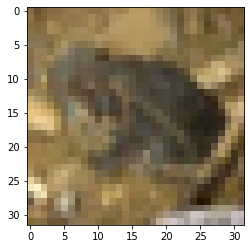

bird


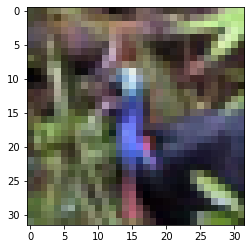

frog


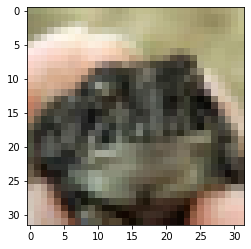

cat


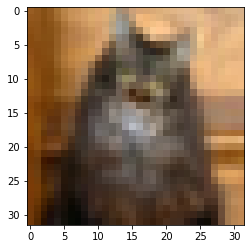

dog


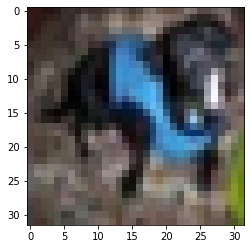

deer


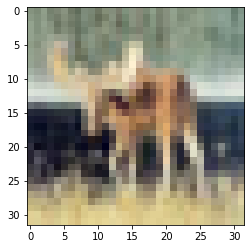

airplane


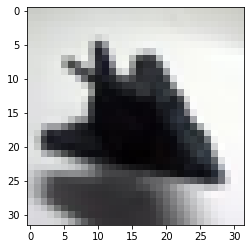

airplane


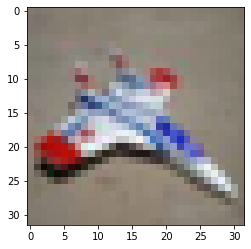

truck


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [41]:
# labelNames = ['desert', 'mountains', 'sea', 'sunset', 'trees']
labelNames = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
import numpy as np
bb = np.fromfile('../data/cifar-10-batches-bin/data_batch_1.bin', dtype='uint8')
# bb = np.fromfile('../data/miml_dataset/bin/data_batch_1.bin', dtype='uint8')
sp_ar = [32, 32]
sp = sp_ar[0]*sp_ar[1]
ct = (sp*3 + 1)

print(len(bb)/ct, len(bb))
for i in range(32):

    print(labelNames[bb[ct*i]])
    img = np.zeros((sp_ar[0], sp_ar[1], 3))
    img[:,:,0] = bb[ct*i + 1 + sp*0: ct*i + 1 + sp*1].reshape(sp_ar[0], sp_ar[1])
    img[:,:,1] = bb[ct*i + 1 + sp*1: ct*i + 1 + sp*2].reshape(sp_ar[0], sp_ar[1])
    img[:,:,2] = bb[ct*i + 1 + sp*2: ct*i + 1 + sp*3].reshape(sp_ar[0], sp_ar[1])
    img = (img - img.min()) / (img.max() - img.min())
    plt.imshow(img)
    plt.show()

In [46]:

dataset_train = Cifar10Dataset(is_train=True)
dataset_eval = Cifar10Dataset(is_train=False)

# dataset_train = MIMLDataset(is_train=True)
# dataset_eval = MIMLDataset(is_train=False)

iterator = dataset_eval.build(False)
sess = tf.compat.v1.Session()

iterator.batch_size = 1

with sess.as_default():
    for j in range(1):
        images, labels = iterator.get_next()
        images, labels = images.eval(), labels.eval()
        for i in range(3):
#         print(images.eval().shape)
            img, lbl = images[i], labels[i]
#             img = img.eval()
            img = np.array(img)
            img = (img - img.min()) / (img.max() - img.min())
#             lbl = lbl.eval()
            print(lbl, np.argmax(lbl))
#             print(labelNames[np.argmax(lbl)], i, j)

            plt.imshow(img)
            plt.show()

OutOfRangeError: End of sequence
	 [[node IteratorGetNext_12 (defined at <ipython-input-46-ee07399e708f>:14) ]]

Caused by op 'IteratorGetNext_12', defined at:
  File "/home/ubuntu/anaconda3/envs/normal/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/anaconda3/envs/normal/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/anaconda3/envs/normal/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/anaconda3/envs/normal/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/ubuntu/anaconda3/envs/normal/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/ubuntu/anaconda3/envs/normal/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/ubuntu/anaconda3/envs/normal/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/ubuntu/anaconda3/envs/normal/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/ubuntu/anaconda3/envs/normal/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/ubuntu/anaconda3/envs/normal/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/ubuntu/anaconda3/envs/normal/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/ubuntu/anaconda3/envs/normal/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/ubuntu/anaconda3/envs/normal/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/ubuntu/anaconda3/envs/normal/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/ubuntu/anaconda3/envs/normal/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/ubuntu/anaconda3/envs/normal/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/ubuntu/anaconda3/envs/normal/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/ubuntu/anaconda3/envs/normal/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/ubuntu/anaconda3/envs/normal/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/ubuntu/anaconda3/envs/normal/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ubuntu/anaconda3/envs/normal/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/normal/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/ubuntu/anaconda3/envs/normal/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/ubuntu/anaconda3/envs/normal/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/ubuntu/anaconda3/envs/normal/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ubuntu/anaconda3/envs/normal/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/ubuntu/anaconda3/envs/normal/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-46-ee07399e708f>", line 14, in <module>
    images, labels = iterator.get_next()
  File "/home/ubuntu/anaconda3/envs/normal/lib/python3.7/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 414, in get_next
    output_shapes=self._structure._flat_shapes, name=name)
  File "/home/ubuntu/anaconda3/envs/normal/lib/python3.7/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1685, in iterator_get_next
    output_shapes=output_shapes, name=name)
  File "/home/ubuntu/anaconda3/envs/normal/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/ubuntu/anaconda3/envs/normal/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/normal/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/home/ubuntu/anaconda3/envs/normal/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

OutOfRangeError (see above for traceback): End of sequence
	 [[node IteratorGetNext_12 (defined at <ipython-input-46-ee07399e708f>:14) ]]


[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0